# Political Ads Investigation Notebook

In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import nltk
import spacy
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
import textacy
import gensim
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib.style as style
sns.set()

[nltk_data] Downloading package stopwords to /Users/philiplockwood-
[nltk_data]     bean/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/philiplockwood-
[nltk_data]     bean/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data reading and cleanup

To download the dataset, use this link: https://www.propublica.org/datastore/dataset/political-advertisements-from-facebook

In [2]:
filepath_to_data = '~/Documents/fb_political_ads_data/data/'

In [3]:
df = pd.read_csv(filepath_to_data + 'fbpac-ads-en-US.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
keep_cols = ['id', 'political', 'not_political', 'title', 'message', 'created_at',
            'updated_at', 'impressions', 'political_probability', 'targets', 'advertiser', 'entities',
            'paid_for_by', 'targetedness']

In [5]:
df = df[keep_cols]

It looks like there are some ads that were picked up that don't have targets. This could be an error on facebook's side, or it could be the scraper--either way, we'll pull them out of the main dataset and hold them for later analysis

In [6]:
# Percentage of dataset with null targets
df.targets.isnull().sum() / df.shape[0]

0.08560048235917488

In [7]:
df = df[~df.targets.isnull()].reset_index(drop=True)

In [8]:
df.shape

(50046, 14)

In [9]:
df['targets2'] = df['targets'].apply(json.loads).values.tolist()

## Parse out the targets to use in investigation

In [10]:
# certain columns are boolean and therefore don't have segments. keep a list of these
# so they can be processed correctly
boolean_targets = ['Activity on the Facebook Family', 'Engaged with Content', 'Like', 'List']

In [11]:
def expand_Col(df, col_name, target_bools, cat_name='target', val_name='segment'):
    df_c = df.copy()
    
    # Convert column into json format from string
    df_c[col_name] = df_c[col_name].apply(json.loads).values.tolist()
    
    # Go through all of the nested entities in each row of the column,
    # keep the unique names of categories
    cats = []
    cat_col_name = 'pos.' + cat_name
    val_name = 'pos.' + val_name
    for i in df_c[col_name]:
        tmp_df = json_normalize(i).add_prefix('pos.')
        #print(tmp_df)
        if tmp_df.empty:
            pass
        else:
            for i in tmp_df[cat_col_name]:
                if i not in cats:
                    cats.append(i)
                    
    # Add the categories as empty columns to the original dataframe, and fill them with
    # the corresponding values
    # Note to self: iterating twice is lazy, come back and make more efficient
    df_c = pd.concat([df_c,pd.DataFrame(columns=cats)])
    for index,row in df_c.iterrows():
        tmp_df = json_normalize(row[col_name]).add_prefix('pos.')
        if tmp_df.empty:
            pass
        else:
            tmp_df = tmp_df.set_index(cat_col_name)
            if val_name in tmp_df.columns:
                tmp_dict = tmp_df[val_name].to_dict()
                for cat in tmp_dict:
                    if cat in target_bools:
                        df_c.loc[index, cat] = 1
                    else:
                        df_c.loc[index, cat] = tmp_dict[cat]
            else:
                print(tmp_dict)

            """
            tmp_df = tmp_df.T
            tmp_df.columns = tmp_df.loc[cat_col_name]
            tmp_df = tmp_df.reindex(tmp_df.index.drop(cat_col_name))
            for val in tmp_df.iloc[0]:
                df_c.loc[index, ] = row.merge(tmp_df, on=tmp_df.columns)
            """

    return df_c

In [12]:
df_expanded = expand_Col(df, 'targets', target_bools=boolean_targets)

{'Age': '64 and older', 'MinAge': '64', 'State': 'Missouri', 'City': 'St. Charles', 'Retargeting': 'people who may be similar to their customers'}
{'Age': '18 and older', 'MinAge': '18', 'City': 'Columbia', 'Interest': 'Feminism', 'State': 'Missouri'}
{'Age': '21 and older', 'MinAge': '21', 'Interest': 'Bernie Sanders', 'Region': 'the United States'}
{'Age': '18 and older', 'MinAge': '18', 'Region': 'the United States', 'List': nan}
{'Age': '18 and older', 'MinAge': '18', 'Interest': 'Environmentalism', 'Region': 'the United States'}
{'Age': '18 and older', 'MinAge': '18', 'Region': 'New Mexico'}
{'Age': '18 and older', 'MinAge': '18', 'Interest': 'Health (magazine)', 'Region': 'Wisconsin'}


In [13]:
df_expanded.targets2[15]

[{'segment': '13 and older', 'target': 'Age'},
 {'segment': '13', 'target': 'MinAge'},
 {'segment': 'Lubbock', 'target': 'City'},
 {'segment': 'Texas', 'target': 'State'}]

Below is the percentage of ads that use targeting in the available categories ("Activity on the Facebook Family" through "Website"). Aside from Age, MinAge, and Region, it looks like City, Interest, List, Retargeting, and State are the most used categories

In [14]:
100 * (1-df_expanded.isnull().sum()/df_expanded.shape[0]).round(3)

Activity on the Facebook Family      2.0
Age                                 89.2
Agency                               0.8
City                                13.8
Engaged with Content                 0.0
Gender                               4.1
Interest                            20.2
Language                             0.4
Like                                 8.8
List                                13.4
MaxAge                               4.3
MinAge                              89.2
Region                              75.0
Retargeting                         22.2
Segment                              6.4
State                               13.8
Website                              5.3
advertiser                          89.9
created_at                         100.0
entities                            96.5
id                                 100.0
impressions                        100.0
message                            100.0
not_political                      100.0
paid_for_by     

In [15]:
df_expanded.Retargeting.value_counts()

people who may be similar to their customers    10747
recently near their business                      339
Name: Retargeting, dtype: int64

In [16]:
top_interests = df_expanded.Interest.value_counts()[:20].reset_index()

In [17]:
top_interests.columns = ['Interest', 'Counts']

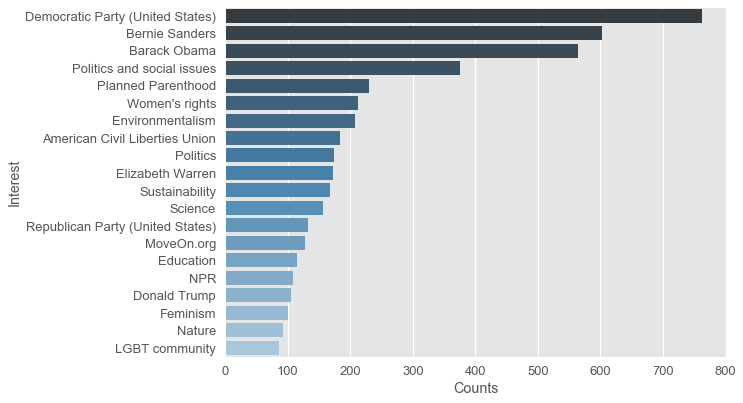

In [18]:
style.use('ggplot')
sns.set_context('talk')
dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
sns.barplot(y='Interest',x='Counts',data=top_interests,palette=("Blues_d"))

In [19]:
df_expanded.advertiser.value_counts()[:20]

International Rescue Committee                                    866
Cathy Myers                                                       778
ACLU                                                              755
Sierra Club                                                       586
Beto O'Rourke                                                     579
Everytown for Gun Safety                                          522
Planned Parenthood Action                                         502
MoveOn.org                                                        486
Environmental Defense Fund                                        459
AAAS - The American Association for the Advancement of Science    453
Planned Parenthood                                                449
Care2                                                             430
National Democratic Redistricting Committee                       421
Randy Bryce                                                       399
NRDC (Natural Resour

### Get ad timeline

In [33]:
df_expanded_ts = df_expanded[['impressions','updated_at']].copy()

In [34]:
df_expanded_ts.updated_at = pd.to_datetime(df_expanded_ts.updated_at)

In [35]:
df_expanded_ts.updated_at = df_expanded_ts.updated_at.dt.date

In [37]:
df_expanded_ts = df_expanded_ts.groupby(['updated_at']).sum()

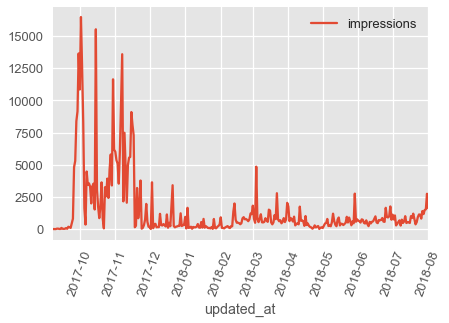

In [42]:
df_expanded_ts.plot(rot=70)

# Deep Dive into How Political Ad Language Differs Among the Dataset

One thing I would love to know is: Are there clear and identifiable differences in the language used for different political groups or causes, and if so, how are they different? After identifying the groups, we can try to investigate how targeting plays into that and how negative the language is etc.

In [43]:
nlp = spacy.load('en_core_web_md')

## Clean up text before doing any analysis

On the first pass, we'll get rid of the html tags

In [44]:
from bs4 import BeautifulSoup

In [45]:
df_expanded['message_clean'] = df_expanded.message.apply(lambda x: BeautifulSoup(x, "lxml").text)

In [46]:
df_expanded['message_clean'].head()

0    Our country is under attack by Donald Trump’s ...
1    The Senate just voted to overturn FCC Chairman...
2    Too many women in Alberta have faced harassmen...
3    I took on the NRA for common-sense gun safety…...
4    Watch this quick message from Kristen Bell on ...
Name: message_clean, dtype: object

We can also remove stop words

In [47]:
stop = stopwords.words('english')

In [48]:
df_expanded['message_clean'] = df_expanded.message_clean.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [49]:
df_expanded['message_clean'].iloc[0]

"Our country attack Donald Trump’s administration. We deserve Congress stand take action. Add name Tom Steyer's petition demanding Congress impeach Trump."

In [50]:
# Additional cleaning for tokenization using spacy
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

We can also lemmatize words which breaks them down to their root in order to compare across documents more evenly

In [51]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)

In [52]:
punctuations = string.punctuation
punctuations = punctuations + '–'
def token_and_lemma_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [tok for tok in tokens if tok not in stop]
    tokens = [tok for tok in tokens if tok.isalpha()]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [53]:
messages_lda = df_expanded['message_clean'].apply(lambda x: token_and_lemma_text_for_lda(x))

In [54]:
beto_ads = df_expanded[df_expanded['title'] == "Beto O'Rourke"]

In [55]:
beto_ads.message.nunique()

198

In [56]:
#print(beto_ads.targets2[:20].values)

In [57]:
df_expanded.title.value_counts()[:20]

Cathy Myers                                                       891
International Rescue Committee                                    863
ACLU                                                              802
Sierra Club                                                       648
Beto O'Rourke                                                     598
Everytown for Gun Safety                                          569
MoveOn.org                                                        543
Planned Parenthood Action                                         529
Care2                                                             501
Environmental Defense Fund                                        491
National Democratic Redistricting Committee                       470
Planned Parenthood                                                457
AAAS - The American Association for the Advancement of Science    445
Randy Bryce                                                       437
NRDC (Natural Resour

In [59]:
df_expanded.sort_values(by='impressions').title[:20]

25374                                         Brian Calley
25593                         Abby Finkenauer for Congress
34447                                  Advocates for Youth
39500                                    Mercy For Animals
10661                                          Sierra Club
8913     Progressive Change Campaign Committee (BoldPro...
11631                   The Wilderness Society Action Fund
13707                       Episcopal Relief & Development
13200                   Parents with Incarcerated Children
43825                       Texas Public Policy Foundation
49772                Steel Valley DSA Organizing Committee
15984                             Everytown for Gun Safety
5295                                             NEA Today
2209                              Ken Calvert For Congress
37814                    Mike Braun Isn't Fooling Hoosiers
25721                                           MoveOn.org
46014                                      Freedom from 

## Topic model

There are a couple of different approaches we could take to try to understand the landscape of comments. We could use a text vectorizer, like TF-IDF, to represent the words used across all of the ads in the dataset, and then look at the distance between documents with a clustering algorithm like K-Means.

We could also use topic modeling, which is similar to K-Means in that it is also an unsupervised modeling technique, which looks to uncover latent topics in the dataset. We'll start with this one to see if we can get sufficient differentiation between topics in the different messages. However, I have doubts that we will see sufficient differentiation, because it seems from a cursory look at the data that it skews overwhelmingly liberal.

In [60]:
messages_lda.head()

0    [country, attack, donald, trump, administratio...
1    [senate, vote, overturn, fcc, chairman, ajit, ...
2    [many, woman, alberta, face, harassment, intim...
3    [take, nra, common, sense, gun, safety, real, ...
4    [watch, quick, message, kristen, bell, need, h...
Name: message_clean, dtype: object

In [61]:
from gensim import corpora
dictionary = corpora.Dictionary(messages_lda)
corpus = [dictionary.doc2bow(text) for text in messages_lda]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

The downside to LDA is that you have to assign the number of topics you believe to be present in the text. For now, we will try with 5 topics

In [62]:
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')

Now let's check out the words associated most strongly with each topic

In [63]:
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.016*"campaign" + 0.016*"election" + 0.014*"help" + 0.011*"us" + 0.011*"win" + 0.010*"need" + 0.009*"people" + 0.009*"make" + 0.009*"donate" + 0.009*"today"')
(1, '0.026*"trump" + 0.016*"sign" + 0.014*"petition" + 0.013*"care" + 0.011*"tax" + 0.010*"health" + 0.010*"right" + 0.009*"stop" + 0.009*"court" + 0.008*"add"')
(2, '0.023*"today" + 0.020*"donate" + 0.020*"fight" + 0.018*"trump" + 0.017*"help" + 0.014*"climate" + 0.013*"protect" + 0.013*"take" + 0.012*"name" + 0.011*"us"')
(3, '0.013*"gun" + 0.011*"join" + 0.010*"community" + 0.009*"vote" + 0.009*"like" + 0.009*"state" + 0.007*"support" + 0.007*"us" + 0.006*"get" + 0.006*"make"')
(4, '0.020*"help" + 0.010*"child" + 0.009*"us" + 0.007*"family" + 0.007*"world" + 0.007*"need" + 0.007*"life" + 0.007*"day" + 0.007*"year" + 0.007*"save"')


Let's try this out on a specific ad and see which topic this ad most likely falls into

In [64]:
test_ad = df_expanded.message_clean.iloc[3]
print(test_ad)

I took NRA common-sense gun safety… won. Real change takes courage. The courage stand up, speak out, protect CA's values.


In [65]:
test_ad = token_and_lemma_text_for_lda(test_ad)
new_doc_bow = dictionary.doc2bow(test_ad)
print(new_doc_bow)
print(ldamodel.get_document_topics(new_doc_bow))

[(12, 1), (14, 2), (54, 1), (55, 1), (56, 1), (57, 2), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1)]
[(0, 0.012031715), (1, 0.012032537), (2, 0.2711065), (3, 0.6929882), (4, 0.011841027)]


You can see here that the ad is correctly associated with the "gun" and "violence" topic (index 4), which seems correct to me!

## Visualizing topics

In [66]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda5 = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda5, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

We can also do a second pass of topic modeling with 10 topics to see if we can capture more granularity

In [67]:
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15,)
#ldamodel = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                           id2word=dictionary,
#                                           num_topics=NUM_TOPICS, 
#                                           random_state=100,
#                                           update_every=1,
#                                           chunksize=100,
#                                           passes=15,
#                                           alpha='auto',
#                                           per_word_topics=True)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=10)
#for topic in topics:
    #print(topic)

(0, '0.038*"gun" + 0.020*"school" + 0.014*"student" + 0.014*"ryan" + 0.013*"paul" + 0.012*"like" + 0.012*"violence" + 0.012*"life" + 0.012*"child" + 0.010*"march"')
(1, '0.030*"trump" + 0.027*"health" + 0.024*"care" + 0.021*"protect" + 0.020*"fight" + 0.017*"climate" + 0.014*"help" + 0.012*"attack" + 0.011*"plan" + 0.011*"us"')
(2, '0.027*"help" + 0.021*"us" + 0.020*"campaign" + 0.016*"today" + 0.015*"need" + 0.013*"make" + 0.012*"every" + 0.012*"donation" + 0.012*"people" + 0.011*"fight"')
(3, '0.031*"help" + 0.015*"child" + 0.014*"us" + 0.013*"family" + 0.013*"world" + 0.013*"need" + 0.012*"life" + 0.012*"home" + 0.011*"save" + 0.010*"refugee"')
(4, '0.025*"election" + 0.020*"today" + 0.020*"vote" + 0.018*"donate" + 0.015*"voter" + 0.015*"make" + 0.013*"right" + 0.012*"name" + 0.011*"candidate" + 0.011*"support"')
(5, '0.053*"trump" + 0.020*"phone" + 0.018*"president" + 0.015*"danny" + 0.012*"family" + 0.011*"donald" + 0.011*"sign" + 0.010*"immigrant" + 0.009*"ohio" + 0.009*"justice"

In [68]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

This is actually very interesting because you get groups of topics (specifically in the left quadrant) that definitely have some overlap but also all seem to have an issue based call to action (supreme court nominee Kavanaugh, guns, climate and then topic 3 with just the generic campaign terms.

## Model Evaluation

The trouble with LDA as a technique for modeling unlabeled data like our ad sample is that you have to set a number of topics as an input for the model. But, what if you don't know how many topics there are? Gut intuition here would lead us to believe that 5 topics is definitely broad enough, but maybe 10 is too many because of the observed overlap in the 10 topic model (this "overlap" is the product of multidimensional scaling to estimate the distance between topics). However, I'd like to quantitatively attempt to identify the correct amount of topics, and we can evaluate the LDA model using the Perplexity and Coherence Score:
 
* Perplexity: Perplexity is calculated by estimating the log likelihood that an unseen document fits into one of the topics. Low perplexity is good, high perplexity is bad.
* Coherence Score: This is a score that, in basic terms, evaluates the top N words in each topic in the list of topics identified. This measure scores the interpretability of a given topic, and a higher score is better

In [69]:
len(dictionary)

25668

In [70]:
# Compute Perplexity
print('\nPerplexity: ', lda5.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda5, texts=messages_lda, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.680771075700878

Coherence Score:  0.3897616990578758


In [71]:
mallet_path = '/anaconda3/pkgs/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=dictionary)

In [72]:
# Show Topics
ldamallet.show_topics(formatted=False)

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=messages_lda, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.49429808587204366


In [132]:
#ldamallet.show_topics(formatted=False)

In [74]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [75]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=messages_lda, start=2, limit=40, step=6)

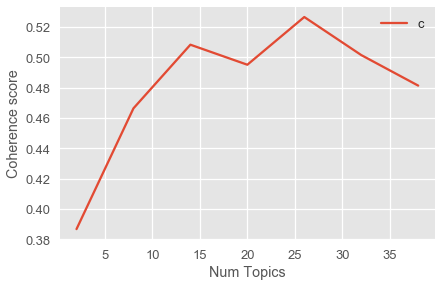

In [76]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [77]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3868
Num Topics = 8  has Coherence Value of 0.4664
Num Topics = 14  has Coherence Value of 0.5084
Num Topics = 20  has Coherence Value of 0.4951
Num Topics = 26  has Coherence Value of 0.5266
Num Topics = 32  has Coherence Value of 0.5015
Num Topics = 38  has Coherence Value of 0.4814


So, it appears as if 26 topics is the sweet spot for this dataset!

In [78]:
best_model = model_list[4]
model_topics = best_model.show_topics(formatted=False)

In [83]:
from pprint import pprint
pprint(best_model.print_topics(num_words=8))

[(25,
  '0.030*"community" + 0.023*"issue" + 0.017*"question" + 0.011*"housing" + '
  '0.010*"work" + 0.010*"support" + 0.009*"challenge" + 0.009*"future"'),
 (18,
  '0.047*"trump" + 0.041*"national" + 0.026*"land" + 0.025*"public" + '
  '0.024*"oil" + 0.020*"administration" + 0.019*"drilling" + 0.019*"open"'),
 (13,
  '0.060*"democrat" + 0.060*"senate" + 0.053*"back" + 0.046*"house" + '
  '0.043*"republican" + 0.025*"fighting" + 0.025*"win" + 0.023*"chance"'),
 (4,
  '0.031*"sign" + 0.024*"save" + 0.024*"petition" + 0.023*"animal" + '
  '0.020*"world" + 0.017*"protect" + 0.014*"ban" + 0.014*"wildlife"'),
 (16,
  '0.099*"today" + 0.082*"fight" + 0.078*"donate" + 0.050*"donation" + '
  '0.049*"gift" + 0.046*"back" + 0.043*"make" + 0.036*"fund"'),
 (9,
  '0.038*"share" + 0.022*"week" + 0.018*"friend" + 0.016*"time" + 0.016*"free" '
  '+ 0.015*"work" + 0.014*"start" + 0.014*"hope"'),
 (10,
  '0.078*"gun" + 0.056*"sign" + 0.046*"petition" + 0.042*"violence" + '
  '0.037*"demand" + 0.024*"n

In [ ]:
def format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=messages_lda):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=best_model, corpus=corpus, texts=df_expanded['message'].values)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
#df_dominant_topic.sort_values(by='Topic_Perc_Contrib').head(10)

Uncomment the 2 lines below for a pretty wonky example of the most dominant example of any of the topics, which was actually written about in this New Yorker article: https://www.newyorker.com/culture/annals-of-gastronomy/ceo-who-called-trump-racist-penzeys-spice-mix

In [133]:
#df_dominant_topic.sort_values(by='Topic_Perc_Contrib', ascending=False).head(20)

In [134]:
#df_dominant_topic.sort_values(by='Topic_Perc_Contrib', ascending=False).head(1)['Text'].values

In [88]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
topic_num_keywords = topic_num_keywords.drop_duplicates().reset_index(drop=True)


# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.sort_values(by='Num_Documents', ascending=False)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
20,5.0,"governor, people, support, big, politics, runn...",2946,0.0589
19,4.0,"sign, save, petition, animal, world, protect, ...",2890,0.0577
22,17.0,"make, people, day, american, support, today, s...",2728,0.0545
3,0.0,"county, state, city, work, community, member, ...",2576,0.0515
10,8.0,"campaign, money, contribution, deadline, grass...",2561,0.0512
6,18.0,"trump, national, land, public, oil, administra...",2466,0.0493
0,1.0,"trump, president, donald, stop, attack, muelle...",2328,0.0465
18,19.0,"change, climate, water, future, clean, energy,...",2241,0.0448
11,6.0,"join, school, march, student, community, educa...",2175,0.0435
21,14.0,"time, support, great, ca, country, message, fr...",2174,0.0434


In [89]:
df_dominant_topics.iloc[9]['Topic_Keywords']

'congress, protect, act, stand, senator, add, time, vote, fighting, call'

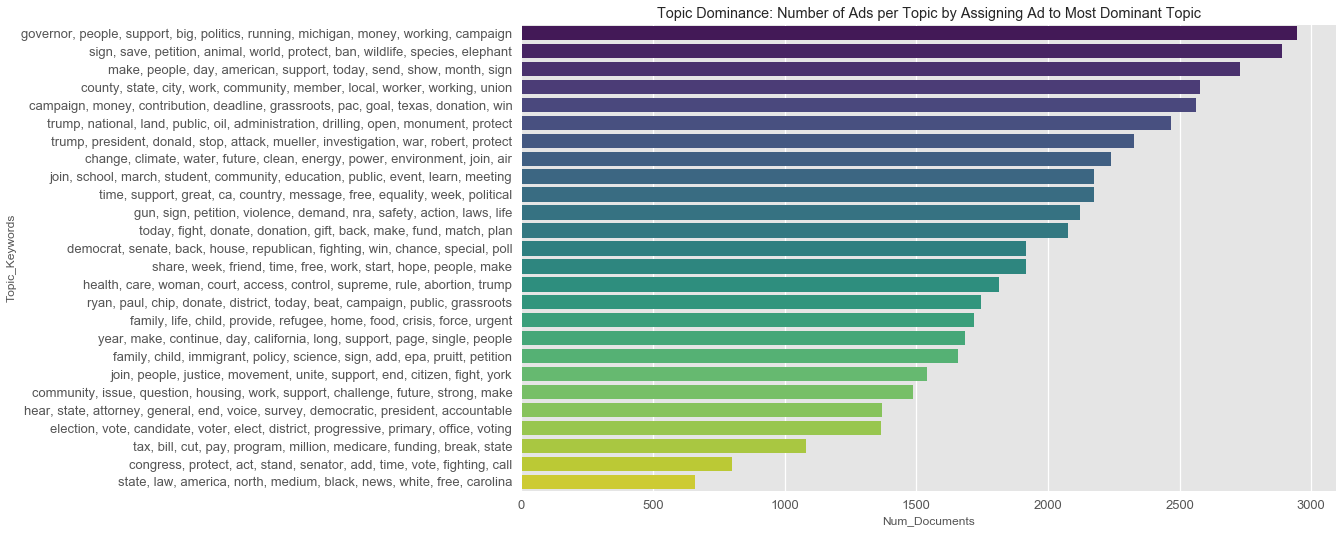

In [104]:
dims = (13, 8)
style.use('ggplot')
plt.tight_layout()
fig, ax = plt.subplots(figsize=dims)
topic_dom = sns.barplot(data=df_dominant_topics.sort_values(by='Num_Documents', ascending=False), x='Num_Documents', y='Topic_Keywords',palette='viridis').set_title('Topic Dominance: Number of Ads per Topic by Assigning Ad to Most Dominant Topic')
fig = topic_dom.get_figure()
fig.savefig('Topic_dominance.png',bbox_inches='tight') 

## Topics and Targeting

It'd be really interesting to look at how different topics may have more or less targeting. If I had more time, I'd take a deep dive into the different kinds of targets that are used, such as retargeting or interest based targeting. However, in the interest of time, I'll use the "targetedness" variable from the dataset as a measure of the granularity 

In [105]:
df_expanded_wtopics = pd.concat([df_expanded, df_dominant_topic], axis=1)

In [106]:
df_expanded_wtopics['Dominant_Topic'] = df_expanded_wtopics['Dominant_Topic'].astype('str')

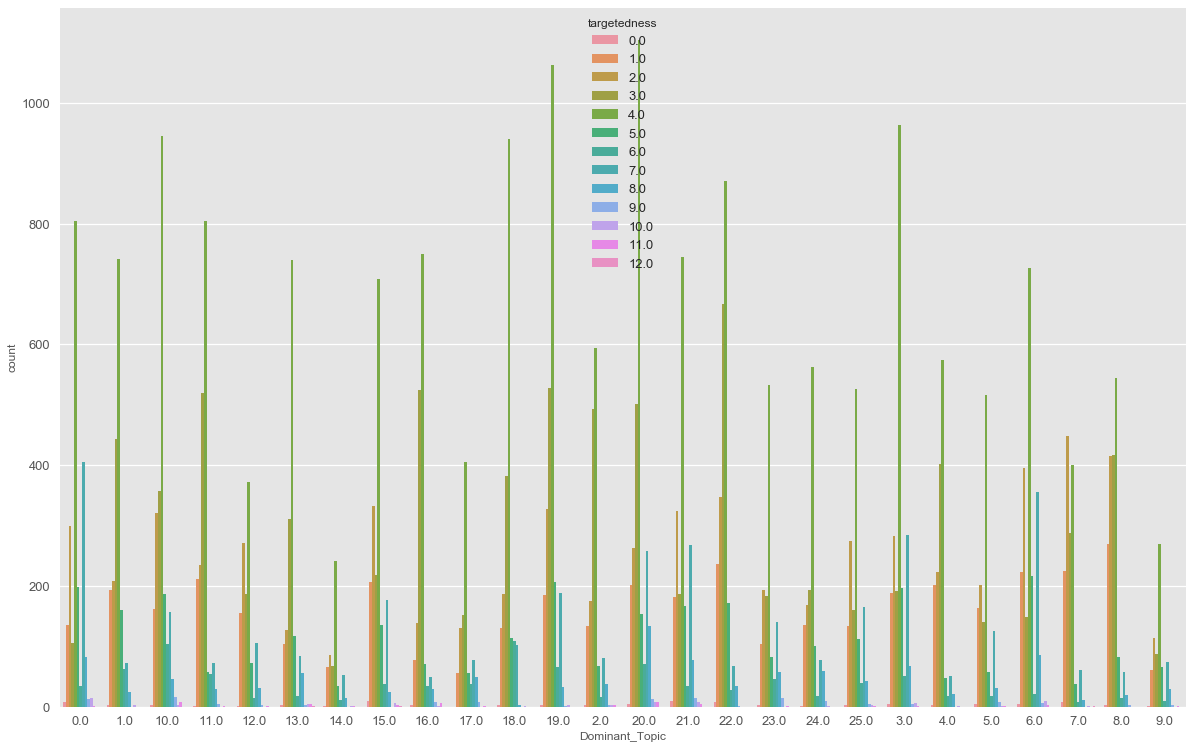

In [107]:
dims = (18, 12)
fig, ax = pyplot.subplots(figsize=dims)
sns.countplot(ax=ax, x="Dominant_Topic", hue="targetedness", data=df_expanded_wtopics)

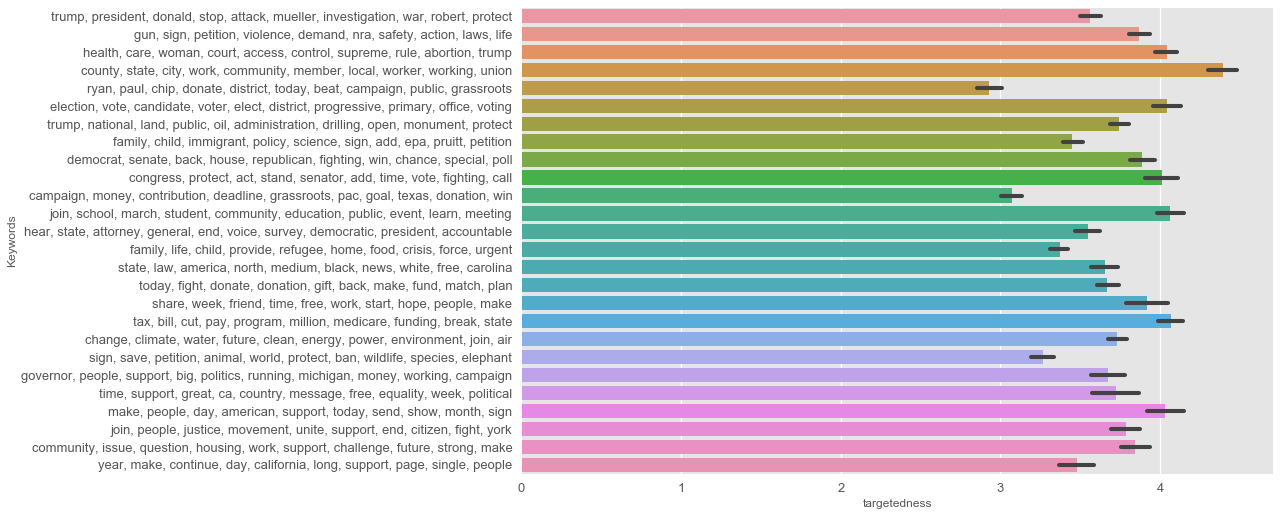

In [108]:
dims = (12, 8)
fig, ax = pyplot.subplots(figsize=dims)
sns.barplot(ax=ax, x="targetedness", y="Keywords", data=df_expanded_wtopics)

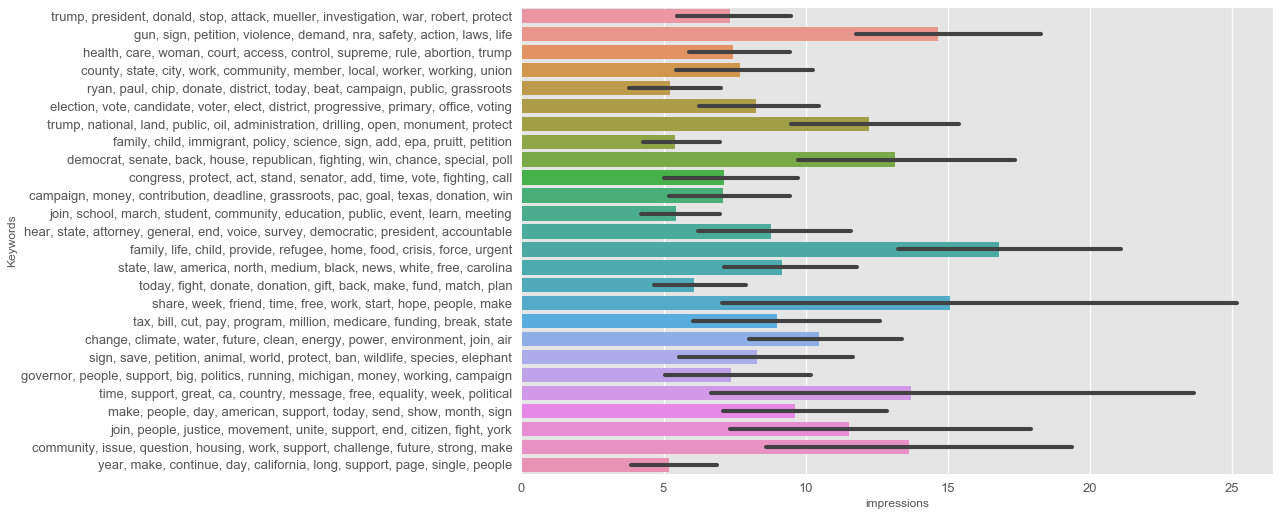

In [109]:
dims = (12, 8)
fig, ax = pyplot.subplots(figsize=dims)
sns.barplot(ax=ax, x="impressions", y="Keywords", data=df_expanded_wtopics)

### Looking at the Difference in Topics Between Democrat Audiences and Republican Audiences

In [118]:
parties = ['Democratic Party (United States)', 'Republican Party (United States)']

In [120]:
partisan_df = df_expanded_wtopics[df_expanded_wtopics.Interest.isin(parties)].copy()
#rep_df = df_expanded_wtopics[df_expanded_wtopics.Interest == 'Republican Party (United States)'].copy()

In [122]:
partisan_df.shape

(895, 38)

In [117]:
dem_df.impressions.sum()

5995.0

In [116]:
rep_df.impressions.sum()

527.0

In [131]:
partisan_df.Interest.value_counts(normalize=True)

Democratic Party (United States)    0.852514
Republican Party (United States)    0.147486
Name: Interest, dtype: float64

So, in looking to observe the difference in topics targeted to Democrats vs. Republicans, a few things are important to note:

* Of all ads observed in this dataset, only 20% target based on Interest, and a much smaller number target these specific interests. Large campaigns often use lists purchased or generated through email campaigns as opposed to Facebook interest targeting.
* Because the sample dataset skews mostly democratic in users, there are many more observations of Demoratic Party targeting than there are of Republican Party targeting (85% vs. 15%). This will lower the significance of differences.

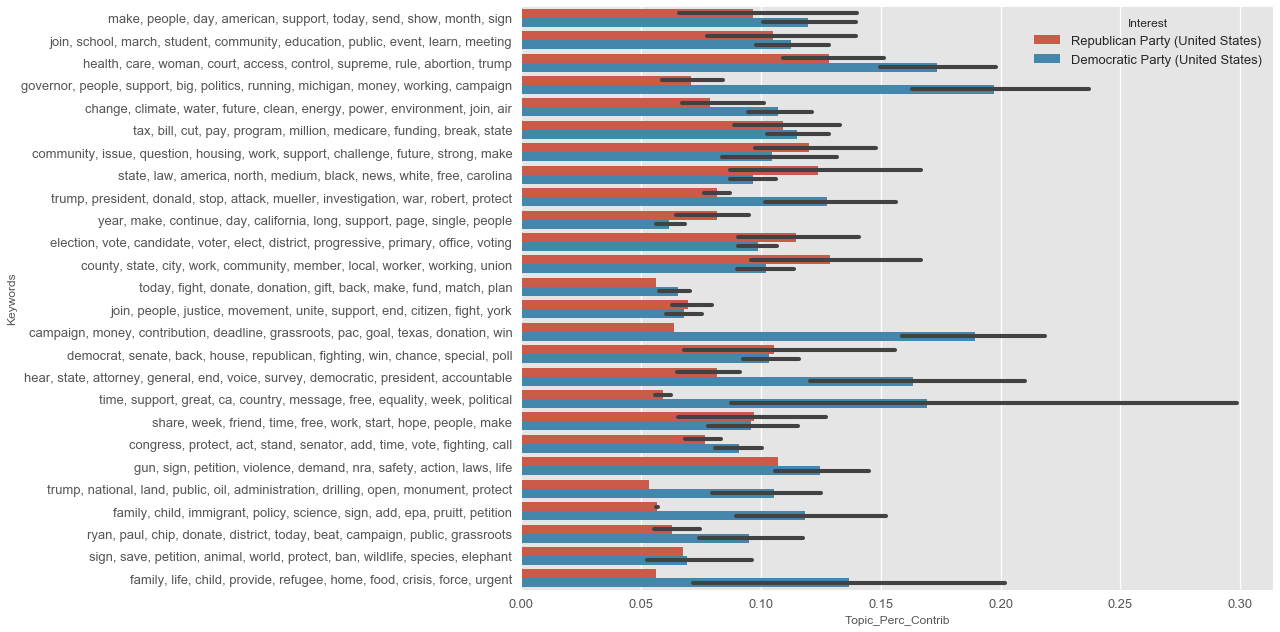

In [129]:
dims = (12, 10)
fig, ax = pyplot.subplots(figsize=dims)
sns.barplot(ax=ax, x="Topic_Perc_Contrib", y="Keywords", hue='Interest', data=partisan_df)